In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

from tensorflow.contrib import learn
# from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.framework import dtypes


import logging
logging.basicConfig(level=logging.INFO)

print('libraries imported!')

def greg():
    return [2 if (1==3) else 3]
greg()

libraries imported!


[3]

# Define our get_data methods

In [2]:
def x_sin(x):
    return x * np.sin(x)


def sin_cos(x):
    return pd.DataFrame(dict(a=np.sin(x), b=np.cos(x)), index=x)



def rnn_data(data, time_steps, labels=False):
    """
    creates new data frame based on previous observation
      * example:
        l = [1, 2, 3, 4, 5]
        time_steps = 2
        -> labels == False [[1, 2], [2, 3], [3, 4]]
        -> labels == True [2, 3, 4, 5]
    """
    rnn_df = []
    for i in range(0,len(data) - time_steps, time_steps):
        if labels:
#             if(len(rnn_df) < 1):
#                 rnn_df.append([4])

            try:
                rnn_df.append(data.iloc[i + time_steps].as_matrix())
            except AttributeError:
                rnn_df.append(data.iloc[i + time_steps])

        else:
            data_ = data.iloc[i: i + time_steps].as_matrix()
            rnn_df.append(data_ if len(data_.shape) > 1 else [[i] for i in data_])
    return np.array(rnn_df)



def split_data(data, test_size, val_size=0):
    """
    splits data to training, validation and testing parts
    """
    ntest = len(data) - test_size
    nval = len(data.iloc[:ntest]) - val_size

    df_train, df_val, df_test = data.iloc[:nval], data.iloc[nval:ntest], data.iloc[ntest:]

    return df_train, df_val, df_test


def prepare_data(data, time_steps, test_size, labels=False, val_size=0):
    """
    Given the number of `time_steps` and some data,
    prepares training, validation and test data for an lstm cell.
    """
    df_train, df_val, df_test = split_data(data, test_size, val_size)
    return (rnn_data(df_train, time_steps, labels=labels),
            rnn_data(df_val, time_steps, labels=labels),
            rnn_data(df_test, time_steps, labels=labels))


def generate_data(fct, x, time_steps, test_size, seperate=False):
    """generates data with based on a function fct"""
    data = fct(x)
#     if not isinstance(data, pd.DataFrame):
#         data = pd.DataFrame(data)
    train_x, val_x, test_x = prepare_data(data, time_steps, test_size)
    train_y, val_y, test_y = prepare_data(data, time_steps, test_size, labels=True)
    return dict(train=train_x, val=val_x, test=test_x), dict(train=train_y, val=val_y, test=test_y)

def f(x):
    return x

greg = pd.Series([1,2,3,4,5,6,7,8,9])
print(generate_data(f,greg,2,8))
print('get_data methods defined')

({'train': array([], dtype=float64), 'val': array([], dtype=float64), 'test': array([[[2],
        [3]],

       [[4],
        [5]],

       [[6],
        [7]]])}, {'train': array([], dtype=float64), 'val': array([], dtype=float64), 'test': array([4, 6, 8])})
get_data methods defined


# Define our LSTM Model

In [22]:
def lstm_model(time_steps, rnn_layers, dense_layers=None):
    print(rnn_layers)
    """
    Creates a deep model based on:
        * stacked lstm cells
        * an optional dense layers
    :param time_steps: the number of time steps the model will be looking at.
    :param rnn_layers: list of int or dict
                         * list of int: the steps used to instantiate the `BasicLSTMCell` cell
                         * list of dict: [{steps: int, keep_prob: int}, ...]
    :param dense_layers: list of nodes for each layer
    :return: the model definition
    """
    sess = tf.Session()
    
    
    def lstm_cells(layers):
        if isinstance(layers[0], dict):
            return [tf.nn.rnn_cell.DropoutWrapper(tf.nn.rnn_cell.BasicLSTMCell(layer['steps'],
                                                                               state_is_tuple=True),
                                                  layer['keep_prob'])
                    if layer.get('keep_prob') else tf.nn.rnn_cell.BasicLSTMCell(layer['steps'],
                                                                                state_is_tuple=True)
                    
                    for layer in layers]
        return [tf.nn.rnn_cell.BasicLSTMCell(steps, state_is_tuple=True) for steps in layers]

    def dnn_layers(input_layers, layers):
        if layers and isinstance(layers, dict):
            return learn.ops.dnn(input_layers,
                                 layers['layers'],
                                 activation=layers.get('activation'),
                                 dropout=layers.get('dropout'))
        elif layers:
            return learn.ops.dnn(input_layers, layers)
        else:
            return input_layers

    def _lstm_model(X, y):
        stacked_lstm = tf.nn.rnn_cell.MultiRNNCell(lstm_cells(rnn_layers), state_is_tuple=True)
        x_ = learn.ops.split_squeeze(1, time_steps, X)
        output, layers = tf.nn.rnn(stacked_lstm, x_, dtype=dtypes.float32)
        output = dnn_layers(output[-1], dense_layers)
        return learn.models.linear_regression(output, y)

    return _lstm_model


print('model defined')


model defined


# Define some variables and run the LSTM model


[{'steps': 5}]
(2, 5, 1)
(2,)
Tensor("output:0", shape=(?,), dtype=float32)
Tensor("Placeholder:0", shape=(?,), dtype=float32)
[ 0.69778621 -0.50883472]
[ 0.68326171 -0.50636564]
MSE: 0.0104177101299


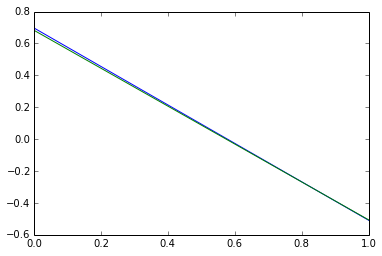

In [23]:
# print(pd.Series(np.linspace(0, 5, 6)))
# X, y = generate_data(np.sin, pd.Series(np.linspace(0, 5, 5)), TIMESTEPS, TESTSIZE, seperate=False)
# print(X)
# print(y)
LOG_DIR = './ops_logs'
TIMESTEPS = 5
TESTSIZE = 11
RNN_LAYERS = [{'steps': TIMESTEPS}]
DENSE_LAYERS = None
TRAINING_STEPS = 500
BATCH_SIZE = 100
PRINT_STEPS = TRAINING_STEPS / 5


regressor = learn.TensorFlowEstimator(model_fn=lstm_model(TIMESTEPS, RNN_LAYERS, DENSE_LAYERS), n_classes=0,
                                      verbose=0,  steps=TRAINING_STEPS, optimizer='Adagrad',
                                      learning_rate=0.03, batch_size=BATCH_SIZE)

X, y = generate_data(np.sin, pd.Series(np.linspace(0, 100, 101)), TIMESTEPS, TESTSIZE, seperate=False)
# print(X)

print(X['test'].shape)
print(y['test'].shape)


# create a lstm instance and validation monitor
# validation_monitor = learn.monitors.ValidationMonitor(X['test'], y['test'],
#                                                       every_n_steps=PRINT_STEPS,
#                                                       early_stopping_rounds=1000)
regressor.fit(X['train'], y['train'])#, monitors=[validation_monitor])#, logdir=LOG_DIR+'greg')


# print(X['train'].shape)
# print(X['val'].shape)
# print(X['test'])
predicted = regressor.predict(X['test'])
print(predicted)
print(y['test'])
rmse = np.sqrt(((predicted - y['test']) ** 2).mean(axis=0))
score = rmse
print ("MSE: " + str(score))
plot_predicted, = plt.plot(predicted, label='predicted')
plot_test, = plt.plot(y['test'], label='test')

sess.close()
# LOG_DIR = './ops_logs'
# TIMESTEPS = 5
# RNN_LAYERS = [{'steps': TIMESTEPS}]
# DENSE_LAYERS = None
# TRAINING_STEPS = 10000
# BATCH_SIZE = 100
# PRINT_STEPS = TRAINING_STEPS / 100

# regressor = learn.TensorFlowEstimator(model_fn=lstm_model(TIMESTEPS, RNN_LAYERS, DENSE_LAYERS), n_classes=0,
#                                       verbose=0,  steps=TRAINING_STEPS, optimizer='Adagrad',
#                                       learning_rate=0.03, batch_size=BATCH_SIZE)

# X, y = generate_data(sin_cos, np.linspace(0, 100, 10000), TIMESTEPS, seperate=False)
# # create a lstm instance and validation monitor
# validation_monitor = learn.monitors.ValidationMonitor(X['val'], y['val'],
#                                                       every_n_steps=PRINT_STEPS,
#                                                       early_stopping_rounds=1000)
# regressor.fit(X['train'], y['train'])#, monitors=[validation_monitor], logdir=LOG_DIR+'0')

MSE: 0.279123113395


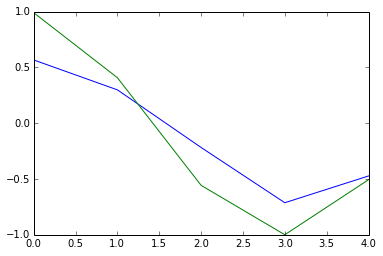

In [189]:
predicted = regressor.predict(X['test'])
rmse = np.sqrt(((predicted - y['test']) ** 2).mean(axis=0))
score = rmse
print ("MSE: " + str(score))
plot_predicted, = plt.plot(predicted, label='predicted')
plot_test, = plt.plot(y['test'], label='test')
# plt.legend(handles=[plot_predicted, plot_test])